In [1]:
from repath.utils.paths import project_root
from repath.preprocess.patching import SlidesIndexResults
import repath.data.datasets.camelyon16 as camelyon16
import repath.data.datasets.camelyon17 as camelyon17

In [2]:
experiment_name = "lee"
experiment_root = project_root() / "experiments" / experiment_name

In [3]:
input_dir16 = experiment_root / "train_index16" / "pre_hnm_results"
input_dir17 = experiment_root / "train_index17" / "pre_hnm_results"

results_dir_name = "results"
heatmap_dir_name = "heatmaps"

train_results16 = SlidesIndexResults.load_results_index(camelyon16.training(), input_dir16, results_dir_name,
                                                        heatmap_dir_name)
train_results17 = SlidesIndexResults.load_results_index(camelyon17.training(), input_dir17, results_dir_name,
                                                        heatmap_dir_name)

In [4]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score, confusion_matrix, cohen_kappa_score

from repath.preprocess.patching import CombinedIndex
from repath.utils.convert import remove_item_from_dict
from repath.utils.metrics import conf_mat_raw, plotROC, plotROCCI, pre_re_curve, save_conf_mat_plot, save_conf_mat_plot_ci


def calc_patch_level_metrics(patches_df: pd.DataFrame, poslabel: int = 2, posname: str = 'tumor', optimal_threshold: float = 0.5) -> pd.DataFrame:
    # for posname column create a boolean mask of values greater than threshold (true means patch is detected as tumor)
    posname_mask = np.greater_equal(patches_df[posname], optimal_threshold)
    # get prediction for each patch which are either poslabel or 0
    predictions = np.where(posname_mask, posname, 'other')
    truenames = np.where(patches_df.label == poslabel, posname, 'other')
    # calculate accuracy for poslabel
    patch_accuracy = np.sum(truenames == predictions) / patches_df.shape[0]
    # calculate number of true postives etc - not using scikit learn function as it is slow
    tn, fp, fn, tp = conf_mat_raw(truenames, predictions,
                                  labels=['other', posname]).ravel()
    # calculate patch recall for poslabel
    patch_recall = tp / (tp + fn)
    # calculate patch specificity for poslabel
    patch_specificity = tn / (tn + fp)
    # calculate patch precision for poslabel
    patch_precision = tp / (tp + fp)
    # write results to list
    patch_results_out = [patch_accuracy, tn, fp, fn, tp, patch_recall, patch_specificity, patch_precision]

    return patch_results_out

In [5]:

def patch_level_metrics(slide_results: List[SlidesIndexResults], save_dir: Path, data_title: str,
                        posname: str = 'tumor', optimal_threshold: float = 0.5, 
                        ci: bool = False, nreps: int = 1000) -> pd.DataFrame:
    # check save directory exists if not make it
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # combine into one set of patches
    all_patches = CombinedIndex.for_slide_indexes(slide_results) 
    
    # remove background from dict and get number that corresponds to poslabel
    # assumes all label dicts are same for multiple datasets so just uses the first one in list
    class_labels = remove_item_from_dict(all_patches.datasets[0].labels, 'background')
    poslabel = class_labels[posname]

    # get one number summaries
    patch_results_out = calc_patch_level_metrics(all_patches.patches_df, poslabel, posname, optimal_threshold)

    # use precision recall from scikit - calculates every threshold
    patch_precisions, patch_recalls, patch_thresholds = precision_recall_curve(all_patches.patches_df.label,
                                                                               all_patches.patches_df[posname],
                                                                               pos_label=poslabel)
    # calculate pr auc
    patch_pr_auc = auc(patch_recalls, patch_precisions)
    # add to list of results
    patch_results_out.append(patch_pr_auc)
    
    # write out precision recall curve - without CI csv and png
    patch_curve = pd.DataFrame(list(zip(patch_precisions, patch_recalls, patch_thresholds)), 
                               columns=['patch_precisions', 'patch_recalls', 'patch_thresholds'])
    patch_curve.to_csv(save_dir / 'patch_pr_curve.csv', index=False)
    title_pr = "Patch Classification Precision-Recall Curve for \n" + data_title
    pr_curve_plt = plotROC(patch_recalls, patch_precisions, patch_pr_auc, title_pr, 'Recall', 'Precision')
    pr_curve_plt.savefig(save_dir/ "patch_pr_curve.png")

    # convert list to dataframe with row name - results
    col_names = ['accuracy', 'tn', 'fp', 'fn', 'tp', 'recall', 'specificity', 'precision', 'auc']
    patch_results_out = pd.DataFrame(np.reshape(patch_results_out, (1, len(patch_results_out))), columns=col_names)
    patch_results_out.index = ['results']
    
    # create confidence matrix plot and write out
    title_cm = "Patch Classification Confusion Matrix for \n" + data_title
    save_conf_mat_plot(patch_results_out[['tn', 'fp', 'fn', 'tp']], ['normal', 'tumor'], title_cm, save_dir)

    if ci:
        # create empty list to store results this will be end up as a list of list
        # more efficient to convert list of lists to pandas dataframe once than append row by row
        patch_ci = []
        # will calculate precision at a specified set of recall levels, this will be the same length for each sample
        # if used precision_recall_curve recalls and length would vary due to different numbers of thresholds
        nrecall_levs = 1001
        # create empty numpy array for storing precisions
        precisions1000 = np.empty((nreps, nrecall_levs))
        # set recall levels
        recall_levels = np.linspace(0.0, 1.0, nrecall_levs)
        for rep in range(nreps):
            print(rep)
            # create bootstrap sample
            sample_patches = all_patches.patches_df.sample(frac=1.0, replace=True)
            # get one number summaries
            ci_results = calc_patch_level_metrics(sample_patches, poslabel, posname, optimal_threshold)
            # get precisions and store
            pre1000 = pre_re_curve(sample_patches.label.to_numpy(), sample_patches[posname].to_numpy(), poslabel, recall_levels)
            precisions1000[rep, :] = pre1000
            # get pr auc
            ci_pr_auc = auc(recall_levels[1:], pre1000[1:])
            # append to this set of results
            ci_results.append(ci_pr_auc)
            # append ci_results to create list of lists of ci_results
            patch_ci.append(ci_results)
 
        # convert list of lists to a dataframe
        patch_ci_df = pd.DataFrame(patch_ci, columns=col_names)

        # name to rows to give sample numbers
        patch_ci_df.index = ['sample_' + str(x) for x in range(nreps)]
        # create confidence intervals for each 
        patch_results_out_ci = patch_ci_df.quantile([0.025, 0.975])
        # rename rows of dataframe
        patch_results_out_ci.index = ['ci_lower_bound', 'ci_upper_bound']

        # concatenate results to give results, confidence interval then all samples
        patch_results_out = pd.concat((patch_results_out, patch_results_out_ci, patch_ci_df), axis=0)

        # create confidence interval for precision recall curve
        precisions_ci = np.quantile(precisions1000, [0.025, 0.975], axis=0)
        # create dataframe with precision recall curve confidence interval
        patch_curve_ci = pd.DataFrame(np.hstack((precisions_ci.T, np.reshape(recall_levels, (1001, 1)))),
                                      columns=['patch_precisions_lower', 'patch_precisions_upper', 'patch_recalls'])
        # write out precision recall curve confidence interval
        patch_curve_ci.to_csv(save_dir / 'patch_pr_curve_ci.csv', index=False)

        # create pr curve with confidence interval
        title_pr = "Patch Classification Precision-Recall Curve for \n" + data_title
        pr_curve_plt = plotROCCI(patch_recalls, patch_precisions, recall_levels, precisions_ci, patch_pr_auc,
                                 patch_results_out_ci.auc.to_list(), title_pr, 'Recall', 'Precision')
        pr_curve_plt.savefig(save_dir / "patch_pr_curve_ci.png")

        # create confidence matrix plot with confidence interval and write out
        title_cm = "Patch Classification Confusion Matrix for \n" + data_title
        save_conf_mat_plot_ci(patch_results_out[['tn', 'fp', 'fn', 'tp']], ['normal', 'tumor'], title_cm, save_dir)

    # write out patch summary result dataframe
    patch_results_out.to_csv(save_dir / 'patch_results.csv')



In [6]:
train_outdir16 = experiment_root / "train_index16" / "pre_hnm_results" / "patch_level_results"

In [7]:
data_title = "lee experiment pre hnm model Camelyon1617 training dataset"

In [8]:
#patch_level_metrics([train_results16], train_outdir16, data_title, 'tumor', 0.5, True, 50)

In [9]:
train_results17_annotated = train_results17.select_annotated()

In [10]:
len(train_results17)

310

In [11]:
len(train_results17_annotated)

31

0


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


1


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


2


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


3


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


4


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


5


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


6


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


7


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


8


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


9


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


10


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


11


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


12


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


13


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


14


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


15


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


16


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


17


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


18


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


19


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


20


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


21


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


22


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


23


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


24


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


25


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


26


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


27


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


28


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


29


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


30


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


31


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


32


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


33


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


34


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


35


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


36


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


37


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


38


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


39


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


40


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


41


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


42


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


43


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


44


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: divide by zero encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


45


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


46


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


47


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


48


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


49


/home/ubuntu/repath/repath/utils/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  precisions = np.divide(tps, np.add(tps, fps))


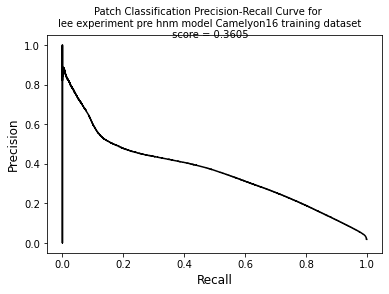

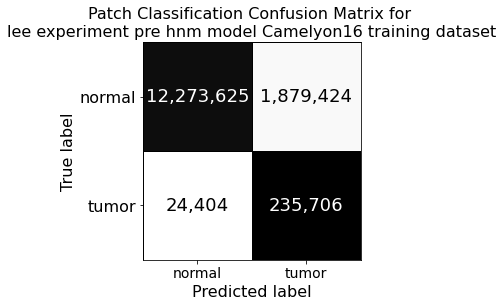

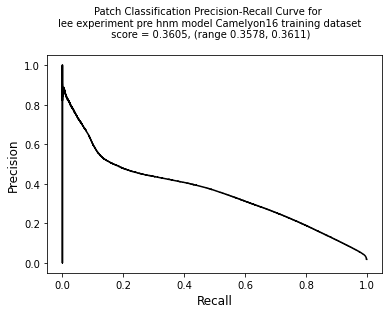

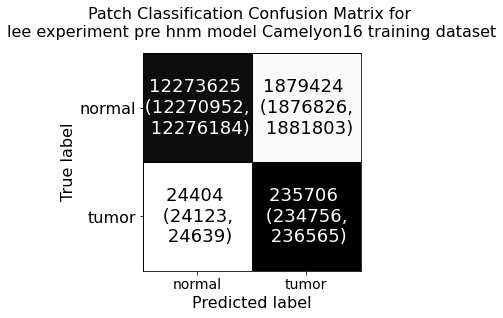

In [13]:
patch_level_metrics([train_results16, train_results17_annotated], train_outdir16, data_title, 'tumor', 0.5, True, 50)